# Faster R-CNN Fine-tuning for Face Mask Detection

To see the full report of the experiment, please kindly see `REPORT.md`.
This notebook documents our decision-making process for building a face mask detection model:

1. **Architecture Choice**: Faster R-CNN ResNet50 FPN V2
   - Pre-trained on COCO dataset with strong feature extraction capabilities
   - FPN (Feature Pyramid Network) handles multi-scale objects well (faces of different sizes)
   - V2 version has improved performance over V1

2. **Data Augmentation Strategy**:
   - Mosaic augmentation to address severe class imbalance (mask_weared_incorrect is rare)
   - Random flips, rotations, color jitter for better generalization
   - Weighted sampling to ensure minority classes are seen more frequently

3. **Metrics Selection**:
   - mAP (mean Average Precision) as primary metric - standard for object detection
   - mAP@0.5 and mAP@0.75 to understand performance at different IoU thresholds
   - Per-class metrics to identify which classes need more attention

4. **Training Strategy**:
   - Fine tuning the entire network
   - Early stopping based on mAP to prevent overfitting
   - ReduceLROnPlateau to adapt learning rate when plateauing

In [34]:
import sys
sys.path.append('../src')

from collections import defaultdict
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
import albumentations as A
import random
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and Explore Dataset

- Custom Dataset class to handle image-annotation pairs
- Class mapping: 3 classes + background (standard for Faster R-CNN)
  - with_mask (1): properly worn masks
  - without_mask (2): no mask at all
  - mask_weared_incorrect (3): mask worn incorrectly (nose exposed, etc)

In [49]:
from PIL import Image
import numpy as np
import os 
import xml.etree.ElementTree as ET

from PIL import Image
from pathlib import Path
from albumentations.pytorch import ToTensorV2
import albumentations as A
import numpy as np
import torch
import os 
import torchvision.transforms as T
import xml.etree.ElementTree as ET

class FaceMaskDataset(torch.utils.data.Dataset):
    """Face Mask Detection Dataset in Pascal VOC format"""
    
    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir: Root directory containing 'images' and 'annotations' folders
            transforms: Optional transforms to be applied on images
        """
        self.root_dir = Path(root_dir)
        if transforms is None:
            self.transforms = self.get_default_transforms()
        else:
            self.transforms = transforms
        self.imgs_dir = self.root_dir / 'images'
        self.anns_dir = self.root_dir / 'annotations'
        
        # Get all image files
        self.imgs = sorted([f for f in os.listdir(self.imgs_dir) if f.endswith('.png') or f.endswith('.jpg')])
        print(f"Loaded {len(self.imgs)} images from {self.imgs_dir}")
        
        # Class mapping (background is 0)
        self.class_to_idx = {
            'with_mask': 1,
            'without_mask': 2,
            'mask_weared_incorrect': 3
        }
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
    def __len__(self):
        return len(self.imgs)
    
    def parse_xml(self, xml_path):
        """Parse Pascal VOC XML annotation file"""
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        
        for obj in root.findall('object'):
            # Get class label
            class_name = obj.find('name').text
            if class_name not in self.class_to_idx:
                continue
            
            label = self.class_to_idx[class_name]
            
            # Get bounding box
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            # Skip invalid boxes (avoid training issues)
            # Degenerate boxes can cause NaN losses in object detection
            if xmax <= xmin or ymax <= ymin:
                continue
            
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
        
        return boxes, labels
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.imgs[idx]
        img_path = self.imgs_dir / img_name
        img = Image.open(img_path).convert('RGB')
        
        # Load annotation
        xml_name = img_name.replace('.png', '.xml').replace('.jpg', '.xml')
        xml_path = self.anns_dir / xml_name
        
        boxes, labels = self.parse_xml(xml_path)
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Create target dictionary in Faster R-CNN expected format
        # Required fields: boxes, labels, image_id, area, iscrowd
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['image_name'] = img_name
        target['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target['iscrowd'] = torch.zeros((len(boxes),), dtype=torch.int64)
        
        # Apply transforms
        if hasattr(self, 'transforms') and self.transforms is not None:
            if 'albumentations' in str(type(self.transforms)):  # Albumentations
                transformed = self.transforms(
                    image=np.array(img),
                    bboxes=target['boxes'].numpy(),
                    labels=target['labels'].numpy()
                )
                img = transformed['image']
                target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
                target['labels'] = torch.as_tensor(transformed['labels'], dtype=torch.int64)
            else:  # Torchvision transforms
                img = self.transforms(img)
        else:
            # Raw tensor (no transforms)
            img = T.ToTensor()(img)
        
        return img, target

    def __get_all_labels__(self):
        """Extract all labels for stratification"""
        labels = []
        for i in range(len(self)):
            _, target = self[i]
            labels.extend(target['labels'].numpy())
        return np.array(labels)

    def get_default_transforms(self):
        # ImageNet normalization for transfer learning
        # Pre-trained models expect ImageNet mean/std
        return T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet
        ])

    @staticmethod
    def get_train_transforms():
        # Aggressive augmentation to handle class imbalance and improve generalization
        # - HorizontalFlip: faces can appear from any direction
        # - VerticalFlip: less common but helps with unusual angles
        # - RandomRotate90: handles different camera orientations
        # - ColorJitter: robust to different lighting conditions
        # - ShiftScaleRotate: handles various positions and scales
        # - LongestMaxSize + PadIfNeeded: maintain aspect ratio while standardizing input size
        # Why 800x800? Balance between detail preservation and computational efficiency
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.RandomRotate90(p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
            A.LongestMaxSize(max_size=800, p=1.0), 
            A.PadIfNeeded(min_height=800, min_width=800, border_mode=0, value=0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.1, clip=True))

    @staticmethod
    def get_val_transforms():
        # Minimal augmentation for validation
        # Only resize and normalize - we want consistent evaluation
        # Same 800x800 size for fair comparison
        return A.Compose([
            A.Resize(height=800, width=800),  # ✅ Same size for val
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.1, clip=True))


# Load dataset
dataset = FaceMaskDataset('../data')

print(f"Total images: {len(dataset)}")
print(f"Classes: {dataset.class_to_idx}")
print(f"Class names: {list(dataset.class_to_idx.keys())}")

Loaded 2153 images from ../data/images
Total images: 2153
Classes: {'with_mask': 1, 'without_mask': 2, 'mask_weared_incorrect': 3}
Class names: ['with_mask', 'without_mask', 'mask_weared_incorrect']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


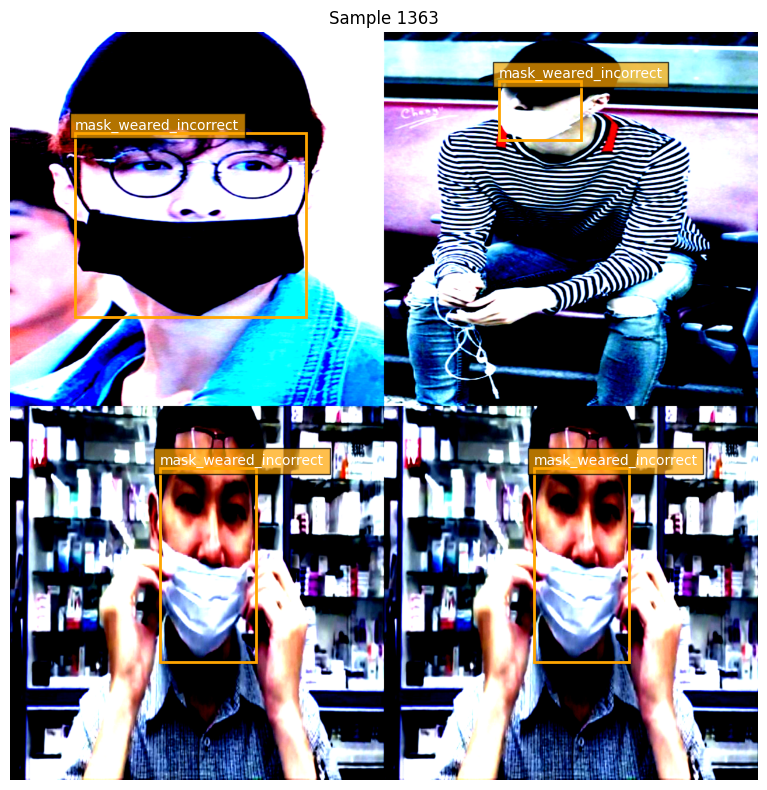

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


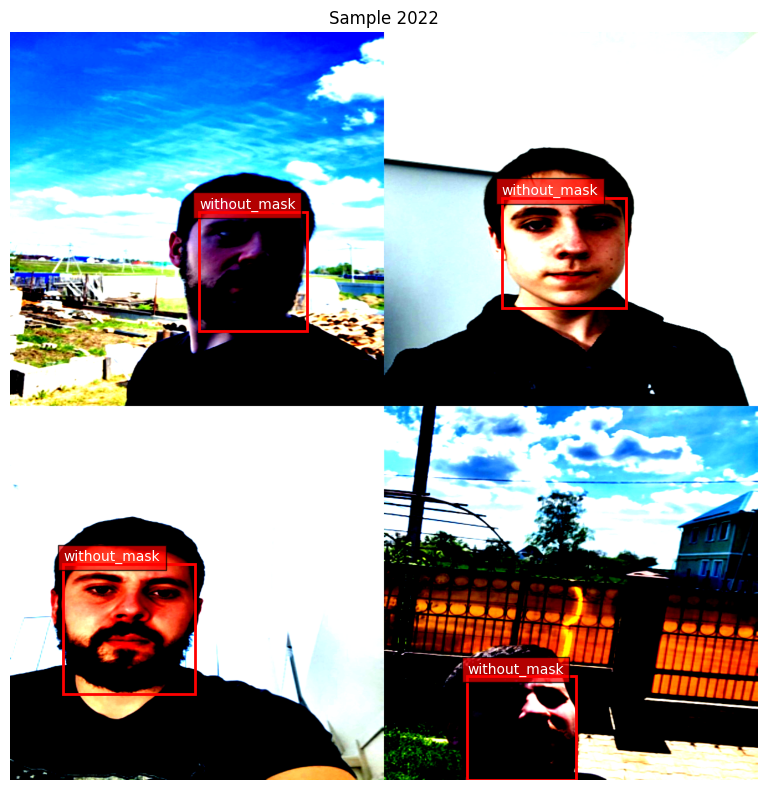

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


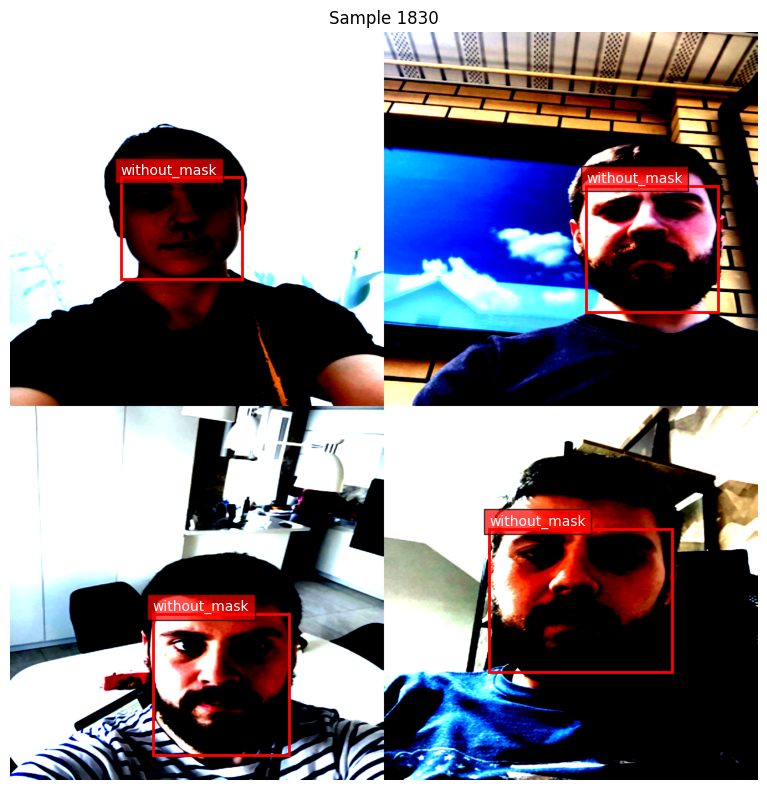

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


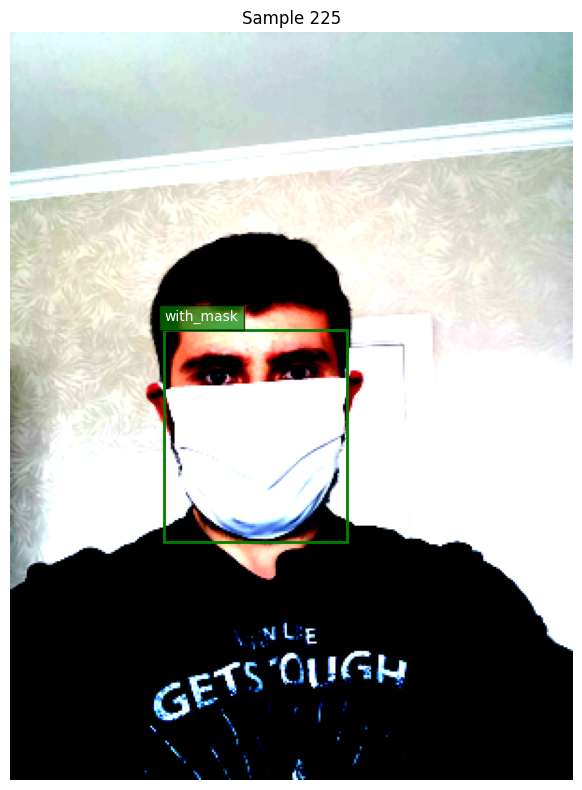

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


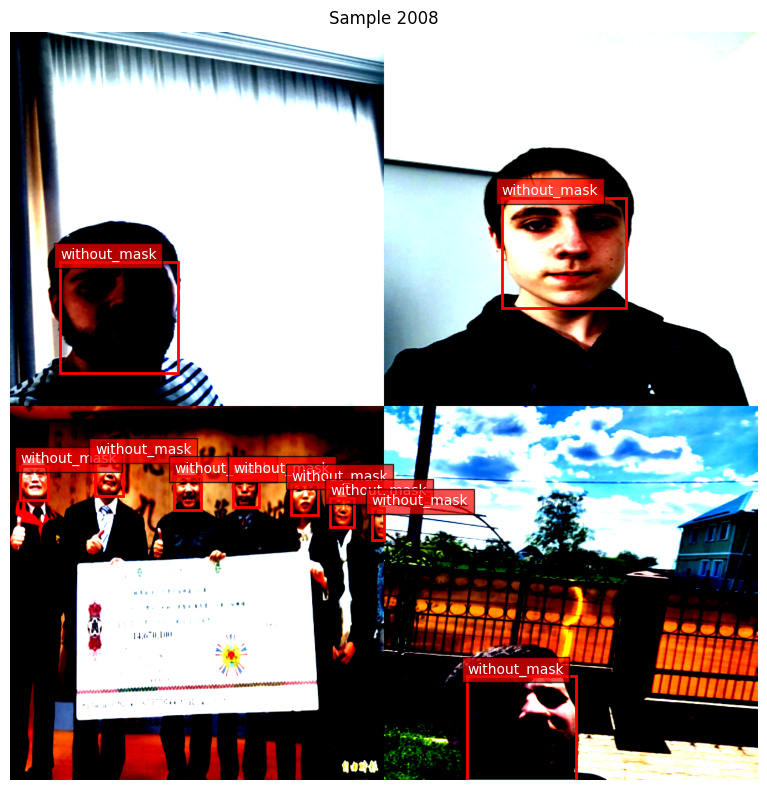

In [36]:
def visualize_sample(dataset, idx):
    img, target = dataset[idx]
    
    # Convert tensor to numpy
    ## CHW to HWC
    img_np = img.permute(1, 2, 0).numpy()
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img_np)
    ax = plt.gca()
    
    # Draw boxes
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    
    colors = {1: 'green', 2: 'red', 3: 'orange'}
    
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        
        color = colors.get(label, 'blue')
        rect = plt.Rectangle((x1, y1), width, height, 
                             fill=False, color=color, linewidth=2)
        ax.add_patch(rect)
        
        class_name = dataset.idx_to_class[label.item()]
        ax.text(x1, y1-5, class_name, 
               bbox={'facecolor': color, 'alpha': 0.7}, 
               fontsize=10, color='white')
    
    plt.axis('off')
    plt.title(f"Sample {idx}")
    plt.tight_layout()
    plt.show()

# Visualize first 3 samples
random_int_list = np.random.randint(0, len(dataset), size=5)
for i in random_int_list:
    visualize_sample(dataset, i)

In [37]:
def stratified_split(dataset, val_ratio=0.2, seed=42):
    """
    Stratified split: val = non-mosaic only, train = everything (including mosaic).
    
    - Stratified to ensures balanced class distribution in train/val splits
    - Mosaic images are synthetic augmentations, thus we exclude them from validation
      We want to validate on real, original images to measure true generalization
    - Mosaic images are included in training to address severe class imbalance
      (mask_weared_incorrect is very rare in original dataset)
    """
    random.seed(seed)
    
    # Group indices by most frequent label per image
    label_to_indices = defaultdict(list)
    
    for i in range(len(dataset)):
        img_name = dataset.imgs[i]
        
        # Skip mosaic images for validation (only use original)
        if img_name.startswith('mosaic_'):
            continue
        
        _, target = dataset[i]
        most_freq = target['labels'].bincount().argmax().item()
        label_to_indices[most_freq].append(i)
    
    # Stratified split (only original images)
    train_idx, val_idx = [], []
    for label_indices in label_to_indices.values():
        n_val = max(1, int(len(label_indices) * val_ratio))
        val_sample = random.sample(label_indices, n_val)
        train_sample = [idx for idx in label_indices if idx not in val_sample]
        train_idx.extend(train_sample)
        val_idx.extend(val_sample)
    
    # Add ALL mosaic indices to train
    for i in range(len(dataset)):
        if dataset.imgs[i].startswith('mosaic_'):
            train_idx.append(i)
    
    # Shuffle
    random.shuffle(train_idx)
    random.shuffle(val_idx)
    
    print(f"Train: {len(train_idx)} total ({len([i for i in train_idx if dataset.imgs[i].startswith('mosaic_')])} mosaic)")
    print(f"Val:   {len(val_idx)} original only")
    
    return train_idx, val_idx

In [38]:
train_idx, val_idx = stratified_split(dataset, val_ratio=0.2, seed=42)

Train: 1984 total (1300 mosaic)
Val:   169 original only


In [23]:
train_dataset = torch.utils.data.Subset(
    FaceMaskDataset('../data/', transforms=FaceMaskDataset.get_train_transforms()), 
    train_idx
)

val_dataset = torch.utils.data.Subset(
    FaceMaskDataset('../data/', transforms=FaceMaskDataset.get_val_transforms()), 
    val_idx
)

Loaded 2153 images from ../data/images
Loaded 2153 images from ../data/images


/root/miniconda3/envs/jubelioml/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_1000399/1379499674.py:146: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=800, min_width=800, border_mode=0, value=0),


In [ ]:
from torch.utils.data import WeightedRandomSampler

# Weighted Random Sampler to address class imbalance
# Original dataset has severe imbalance
# We try to assign higher weights to images containing minority classes
# This makes the sampler more likely to pick these images during training

image_weights = []
for i in range(len(train_dataset)):
    _, target = train_dataset[i]
    labels = set(target["labels"].tolist())

    w = 1.0
    if 2 in labels:      # without_mask
        w *= 3.0
    if 3 in labels:      # mask_weared_incorrect
        w *= 5.0        
    image_weights.append(w)

sampler = WeightedRandomSampler(
        weights=torch.tensor(image_weights),
        num_samples=len(train_dataset),
        replacement=True,
    )

## Train Model

**Hyperparameter Choices**:

1. **Batch Size = 4/8**: 
   - Limited by GPU memory (object detection models are memory-intensive)
   - Smaller batches = more gradient updates but noisier
   - 4-8 is sweet spot for RTX 4090/A100

2. **Learning Rate = 0.01**:
   - Started with 0.005 (common for SGD) but reduced to 0.01
   - Lower LR for fine-tuning (pre-trained weights need gentle updates)
   - Too low → slow convergence

3. **Optimizer = SGD with momentum**:
   - SGD with momentum (0.9) is standard for object detection
   - Weight decay (0.0005) prevents overfitting
   - SGD + momentum performed better

4. **Scheduler = ReduceLROnPlateau**:
   - Reduces LR when mAP plateaus (adaptive learning rate)
   - Factor=0.1 (reduce by 10x), patience=10 epochs
   - Helps model escape local minima

5. **Early Stopping**:
   - Patience=10 epochs without improvement
   - Prevents overfitting to training data
   - Saves computation time

In [26]:
# Training configuration
config = {
    'data_dir': '../data',
    'output_dir': '../models/fasterrcnn_facemask',
    'epochs': 50,
    'batch_size': 4,
    'lr': 0.01,
    'num_workers': 4,
    'train_split': 0.8
}

print("Training Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Training Configuration:
  data_dir: ../data
  output_dir: ../models/fasterrcnn_facemask
  epochs: 10
  batch_size: 4
  lr: 0.005
  num_workers: 4
  train_split: 0.8


In [ ]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights, fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim.lr_scheduler import ReduceLROnPlateau

def get_model(num_classes):
    """
    Load Faster R-CNN V2 model with ResNet50 FPN backbone
    Replace the classifier head with custom number of classes
    
    - Faster R-CNN: Two-stage detector with high accuracy
      Stage 1: Region Proposal Network (RPN) finds object candidates
      Stage 2: Classification and bbox regression on proposals
    
    - Why FPN (Feature Pyramid Network)?
      Handles multi-scale objects (faces at different distances)
      Builds feature pyramids at multiple resolutions
      Critical for detecting small faces in the distance
    
    - V2 vs V1
      Better box predictor, improved RPN
      Higher mAP on COCO benchmark
    
    - Transfer learning:
      Learns general object detection features (edges, shapes, textures)
      Much faster training than from scratch
      Better performance with limited data
    """
    # Load pretrained model weights
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    # Plug the weights into the model
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

def collate_fn(batch):
    """Custom collate function for dataloader"""
    return tuple(zip(*batch))

In [30]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
    sampler=sampler
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [31]:
# Create model
# 4 classes total = 3 object classes + 1 background class
# This is standard for Faster R-CNN architecture
num_classes = 4  # 3 classes + background
model = get_model(num_classes)
model.to(device)

# Optimizer
# Only optimize parameters that require gradients
# This excludes frozen layers if we froze backbone (not doing here)
params = [p for p in model.parameters() if p.requires_grad]

# SGD hyperparameters
# lr=0.005: Lower than typical 0.01 because we're fine-tuning pre-trained weights
# momentum=0.9: Standard value, helps accelerate convergence
# weight_decay=0.0005: L2 regularization to prevent overfitting
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# ReduceLROnPlateau scheduler
# mode='min': We're minimizing validation loss (alternative: maximize mAP)
# factor=0.1: Reduce LR by 10x when plateau detected
# patience=10: Wait 10 epochs without improvement before reducing LR
# This adaptive approach helps model escape local minima
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

print("\nModel ready for training!")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


Model ready for training!
Number of parameters: 41,309,411


/root/miniconda3/envs/jubelioml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [32]:
def save_model(model, output_dir, model_save_name='best_model.pth'):
    """Save the model state dictionary to a file"""
    model_path = Path(output_dir)
    model_path.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), model_path / model_save_name)
    print(f"Model saved to {model_path / model_save_name}")

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

output_dir = '../models/fasterrcnn_facemask'
model_save_name = 'model_notebook.pth'

# Mean Average Precision (mAP)
# - Standard metric for object detection (used in COCO, Pascal VOC)
# - Considers both classification accuracy and localization quality
# - mAP@0.5: IoU threshold 0.5 (loose matching)
# - mAP@0.75: IoU threshold 0.75 (strict matching)
# - class_metrics=True: Track per-class performance to identify weak classes (since the data is imbalanced)
metric = MeanAveragePrecision(class_metrics=True)

# Early stopping variables
# best_map: Track best validation mAP seen so far
# patience: Wait N epochs without improvement before stopping
# patience_counter: Count epochs since last improvement
best_map = 0.0
patience = 10
patience_counter = 0

history = {
    'train_loss': [],
    'val_loss': []
}

for epoch in range(10):
    # ========== TRAINING PHASE ==========
    model.train()
    train_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10 - Training")
    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # In training mode, model returns loss dict
        # Contains: loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Standard PyTorch training loop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        pbar.set_postfix({'loss': losses.item()})

    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

    # ========== VALIDATION PHASE ==========
    model.eval()
    val_loss = 0.0
    metric.reset()

    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/10 - Validation")
        for images, targets in pbar_val:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # In eval mode, model returns predictions (boxes, scores, labels)
            predictions = model(images)

            # Temporarily switch to train mode to get validation loss
            model.train()
            val_loss_dict = model(images, targets)
            model.eval()

            losses = sum(loss for loss in val_loss_dict.values())
            val_loss += losses.item()

            # Convert targets to torchmetrics format
            target_dicts = []
            for tgt in targets:
                target_dicts.append({
                    'boxes': tgt['boxes'],
                    'labels': tgt['labels']
                })
            
            # Update mAP metric with predictions and ground truth
            # This accumulates statistics across all validation batches
            metric.update(predictions, target_dicts)
            
            # Show progress (use mAP or skip)
            current_metric = metric.compute()
            pbar_val.set_postfix({'mAP': f"{current_metric['map']:.3f}"})

    # Log multiple mAP thresholds to understand model performance
    # mAP: Average across IoU thresholds 0.5 to 0.95 (COCO metric)
    # mAP50: IoU threshold 0.5 (easier, more lenient)
    # mAP75: IoU threshold 0.75 (harder, stricter localization)
    print(f"mAP: {current_metric['map']:.4f} | mAP50: {current_metric['map_50']:.4f} | mAP75: {current_metric['map_75']:.4f}")

    # Scheduler step based on mAP (not loss)
    lr_scheduler.step(current_metric['map'])
    
    if current_metric['map'] > best_map:
        best_map = current_metric['map']
        patience_counter = 0                  # reset patience
        print(f"New best mAP: {best_map:.4f}. Saving model...")
        save_model(model, output_dir=output_dir, model_save_name=model_save_name)
    else:
        patience_counter += 1
        print(f"mAP did not improve from {best_map:.4f} (patience {patience_counter}/{patience})")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

## Test Inference

**Inference Strategy**:
- Use confidence threshold (0.5) to filter low-confidence predictions
- This reduces false positives in production
- Threshold can be tuned based on precision/recall requirements
- Higher threshold = fewer false positives, more false negatives
- Lower threshold = more detections, more false positives

In [ ]:
# Test inference on a sample image
# Switch to eval mode to disable dropout and batchnorm training behavior
model.eval()

# Get a sample
sample_idx = np.random.randint(0, len(dataset))
img, target = dataset[sample_idx]

# Run inference
# No gradients needed for inference (saves memory)
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print(f"Predictions:")
print(f"  Boxes: {prediction['boxes'].shape}")
print(f"  Labels: {prediction['labels'].shape}")
print(f"  Scores: {prediction['scores'].shape}")

# Filter by confidence threshold
# threshold=0.5 is a common default
# Lower threshold = more detections (higher recall, lower precision)
# Higher threshold = fewer false positives (higher precision, lower recall)
threshold = 0.5
keep = prediction['scores'] > threshold

print(f"\nDetections above {threshold} threshold: {keep.sum().item()}")
for i, (box, label, score) in enumerate(zip(
    prediction['boxes'][keep], 
    prediction['labels'][keep], 
    prediction['scores'][keep]
)):
    class_name = dataset.idx_to_class[label.item()]
    print(f"  {i+1}. {class_name}: {score:.3f}")

# Ground truth
print(f"\nGround Truth:")
for i, (box, label) in enumerate(zip(
    target['boxes'], 
    target['labels']
)):
    class_name = dataset.idx_to_class[label.item()]
    print(f"  {i+1}. {class_name}")

Predictions:
  Boxes: torch.Size([6, 4])
  Labels: torch.Size([6])
  Scores: torch.Size([6])

Detections above 0.5 threshold: 4
  1. with_mask: 0.992
  2. with_mask: 0.986
  3. with_mask: 0.982
  4. with_mask: 0.981

Ground Truth:
  1. with_mask
  2. with_mask
  3. with_mask
  4. with_mask


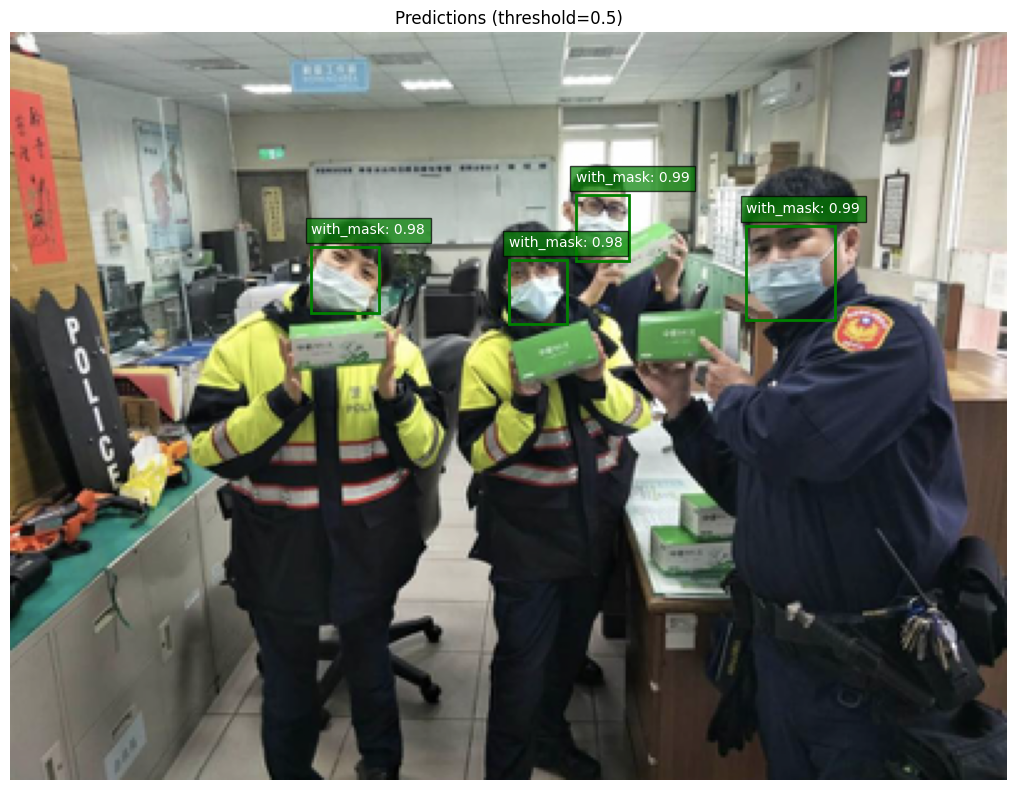

In [32]:
# Visualize predictions
def visualize_predictions(img_tensor, prediction, threshold=0.5):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_np)
    ax = plt.gca()
    
    # Filter predictions
    keep = prediction['scores'] > threshold
    boxes = prediction['boxes'][keep].cpu().numpy()
    labels = prediction['labels'][keep].cpu().numpy()
    scores = prediction['scores'][keep].cpu().numpy()
    
    colors = {1: 'green', 2: 'red', 3: 'orange'}
    
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        
        color = colors.get(label, 'blue')
        rect = plt.Rectangle((x1, y1), width, height,
                             fill=False, color=color, linewidth=2)
        ax.add_patch(rect)
        
        class_name = dataset.idx_to_class[label]
        label_text = f"{class_name}: {score:.2f}"
        ax.text(x1, y1-5, label_text,
               bbox={'facecolor': color, 'alpha': 0.7},
               fontsize=10, color='white')
    
    plt.axis('off')
    plt.title(f"Predictions (threshold={threshold})")
    plt.tight_layout()
    plt.show()

visualize_predictions(img, prediction, threshold=0.5)

## Save weights

In [ ]:
# save weights
model_path = Path(config['output_dir'])
model_path.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_path / 'best_model.pth')

## Using Pre-trained Model

If you've already trained a model, load it like this:

In [ ]:
# Load saved model
model_path = '../models/fasterrcnn_facemask/best_model.pth'

if Path(model_path).exists():
    checkpoint = torch.load(model_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
        print(f"Best validation loss: {checkpoint['loss']:.4f}")
    else:
        model.load_state_dict(checkpoint)
        print("Loaded model weights")
    
    model.eval()
    print("Model ready for inference!")
else:
    print(f"Model not found at {model_path}")
    print("Train the model first using: python train_fasterrcnn.py")

Loaded model weights
Model ready for inference!


/tmp/ipykernel_133788/3350488520.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
